In [1]:
import copy

from tqdm import tqdm

import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
import time
from random import randint

import numpy as np
from scipy import stats
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import KFold

import nibabel as nib
import pydicom as pdm
import nilearn as nl
import nilearn.plotting as nlplt
import h5py

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.animation as anim
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec

import seaborn as sns
import imageio
from skimage.transform import resize
from skimage.util import montage

from IPython.display import Image as show_gif
from IPython.display import clear_output
from IPython.display import YouTubeVideo

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn import MSELoss

import albumentations as A
from albumentations import Compose, HorizontalFlip
from albumentations.pytorch import  ToTensorV2
import  gc
import warnings
warnings.simplefilter("ignore")



C:\Users\NEW\anaconda3\envs\kofi\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\NEW\anaconda3\envs\kofi\Lib\site-packages\albumentations\__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.17 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:

class Image3dToGIF3d:
    """
    Displaying 3D images in 3d axes.
    Parameters:
        img_dim: shape of cube for resizing.
        figsize: figure size for plotting in inches.
    """

    def __init__(self,
                 img_dim: tuple = (55, 55, 55),
                 figsize: tuple = (15, 10),
                 binary: bool = False,
                 normalizing: bool = True,
                 ):
        """Initialization."""
        self.img_dim = img_dim
        print(img_dim)
        self.figsize = figsize
        self.binary = binary
        self.normalizing = normalizing

    def _explode(self, data: np.ndarray):
        """
        Takes: array and return an array twice as large in each dimension,
        with an extra space between each voxel.
        """
        shape_arr = np.array(data.shape)
        size = shape_arr[:3] * 2 - 1
        exploded = np.zeros(np.concatenate([size, shape_arr[3:]]),
                            dtype=data.dtype)
        exploded[::2, ::2, ::2] = data
        return exploded

    def _expand_coordinates(self, indices: np.ndarray):
        x, y, z = indices
        x[1::2, :, :] += 1
        y[:, 1::2, :] += 1
        z[:, :, 1::2] += 1
        return x, y, z

    def _normalize(self, arr: np.ndarray):
        """Normilize image value between 0 and 1."""
        arr_min = np.min(arr)
        return (arr - arr_min) / (np.max(arr) - arr_min)

    def _scale_by(self, arr: np.ndarray, factor: int):
        """
        Scale 3d Image to factor.
        Parameters:
            arr: 3d image for scalling.
            factor: factor for scalling.
        """
        mean = np.mean(arr)
        return (arr - mean) * factor + mean

    def get_transformed_data(self, data: np.ndarray):
        """Data transformation: normalization, scaling, resizing."""
        if self.binary:
            resized_data = resize(data, self.img_dim, preserve_range=True)
            return np.clip(resized_data.astype(np.uint8), 0, 1).astype(np.float32)

        norm_data = np.clip(self._normalize(data) - 0.1, 0, 1) ** 0.4
        scaled_data = np.clip(self._scale_by(norm_data, 2) - 0.1, 0, 1)
        resized_data = resize(scaled_data, self.img_dim, preserve_range=True)

        return resized_data

    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib import cm
    import imageio
    from tqdm import tqdm

    def plot_cube(self,
                  cube,
                  title: str = '',
                  init_angle: int = 0,
                  make_gif: bool = False,
                  path_to_save: str = 'filename.gif'):
        """
        Plot 3D data.

        Parameters:
            cube: 3D data.
            title: Title for the figure.
            init_angle: Initial angle for the 3D plot (from 0-360 degrees).
            make_gif: If True, create a GIF by rotating the plot and capturing every 5th frame.
            path_to_save: Path to save the GIF file.
        """
        if self.binary:
            facecolors = cm.winter(cube)
            print("binary")
        else:
            if self.normalizing:
                cube = self._normalize(cube)
            facecolors = cm.gist_stern(cube)
            print("not binary")

        # Ensure the alpha channel is correctly assigned
        facecolors[:, :, :, -1] = cube

        # Explode the facecolors (ensure this method preserves the intended shape)
        facecolors = self._explode(facecolors)

        # Create filled mask for the voxels (True where cube is not zero)
        filled = facecolors[:, :, :, -1] != 0

        # Create voxel coordinates (ensure shapes match)
        # np.indices creates a grid of indices with shape (3, 240, 240, 156)
        # self._expand_coordinates should process this into x, y, z with shape (240, 240, 156)
        indices = np.indices(np.array(filled.shape) + 1)
        x, y, z = self._expand_coordinates(indices)

        # Corrected Sanity Check
        expected_shape = tuple(s + 1 for s in filled.shape)
        if not (x.shape == y.shape == z.shape == expected_shape):
            raise ValueError(
                f"Shape mismatch: x.shape={x.shape}, y.shape={y.shape}, z.shape={z.shape}, "
                f"expected_shape={expected_shape}, filled.shape={filled.shape}"
            )

        with plt.style.context("dark_background"):
            fig = plt.figure(figsize=self.figsize)
            ax = fig.add_subplot(111, projection='3d')

            # Set initial view angle
            ax.view_init(30, init_angle)
            ax.set_xlim(right=self.img_dim[0] * 2)
            ax.set_ylim(top=self.img_dim[1] * 2)
            ax.set_zlim(top=self.img_dim[2] * 2)
            ax.set_title(title, fontsize=18, y=1.05)

            # Plot the voxels
            ax.voxels(x, y, z, filled, facecolors=facecolors, shade=False)

            if make_gif:
                images = []
                for angle in tqdm(range(0, 360, 5)):
                    ax.view_init(30, angle)
                    fname = f"{angle}.png"

                    plt.savefig(fname, dpi=120, format='png', bbox_inches='tight')
                    images.append(imageio.imread(fname))
                    # Optionally remove temp files
                    # os.remove(fname)
                imageio.mimsave(path_to_save, images)
                plt.close()
            else:
                plt.show()

    # %%
    import os
    import imageio
    import numpy as np

    def merging_two_gif(path1: str, path2: str, name_to_save: str):
        """
        Merges two GIFs side by side.

        Parameters:
            path1 (str): Path to the first GIF (e.g., ground truth).
            path2 (str): Path to the second GIF (e.g., prediction).
            name_to_save (str): Name for saving the new merged GIF.
        """
        # Print and validate input paths
        print(f"Checking if the file exists at path1: {os.path.abspath(path1)}")
        print(f"Checking if the file exists at path2: {os.path.abspath(path2)}")

        if not os.path.isfile(path1):
            raise FileNotFoundError(f"The file at path1 does not exist: {path1}")
        if not os.path.isfile(path2):
            raise FileNotFoundError(f"The file at path2 does not exist: {path2}")

        try:
            # Create reader objects for the GIFs
            gif1 = imageio.get_reader(path1)
            gif2 = imageio.get_reader(path2)

            # Check the number of frames in each GIF
            number_of_frames1 = gif1.get_length()
            number_of_frames2 = gif2.get_length()

            # Take the shorter of the two GIFs
            number_of_frames = min(number_of_frames1, number_of_frames2)

            if number_of_frames == 0:
                raise ValueError("One or both of the GIFs have no frames.")

            # Create a writer object for the new GIF
            with imageio.get_writer(name_to_save) as new_gif:
                for frame_number in range(number_of_frames):
                    try:
                        img1 = gif1.get_data(frame_number)
                        img2 = gif2.get_data(frame_number)

                        # Check if both frames have the same height
                        if img1.shape[0] != img2.shape[0]:
                            raise ValueError("The GIFs have different heights and cannot be merged side by side.")

                        # Merge the frames side by side
                        new_image = np.hstack((img1, img2))
                        new_gif.append_data(new_image)

                    except IndexError as e:
                        print(f"Frame {frame_number} could not be read: {e}")
                        break

        except Exception as e:
            print(f"An error occurred: {e}")
        finally:
            gif1.close()
            gif2.close()


In [3]:

class ShowResult:

    def mask_preprocessing(self, mask):
        """
        Test.
        """
        mask = mask.squeeze().cpu().detach().numpy()
        mask = np.moveaxis(mask, (0, 1, 2, 3), (0, 3, 2, 1))

        mask_WT = np.rot90(montage(mask[0]))
        mask_TC = np.rot90(montage(mask[1]))
        mask_ET = np.rot90(montage(mask[2]))

        return mask_WT, mask_TC, mask_ET

    def image_preprocessing(self, image):
        """
        Returns image flair as mask for overlaping gt and predictions.
        """
        image = image.squeeze().cpu().detach().numpy()
        image = np.moveaxis(image, (0, 1, 2, 3), (0, 3, 2, 1))
        flair_img = np.rot90(montage(image[0]))
        return flair_img

    def plot(self, image, ground_truth, prediction):
        image = self.image_preprocessing(image)
        gt_mask_WT, gt_mask_TC, gt_mask_ET = self.mask_preprocessing(ground_truth)
        pr_mask_WT, pr_mask_TC, pr_mask_ET = self.mask_preprocessing(prediction)

        fig, axes = plt.subplots(1, 2, figsize=(35, 30))

        [ax.axis("off") for ax in axes]
        axes[0].set_title("Ground Truth", fontsize=35, weight='bold')
        axes[0].imshow(image, cmap='bone')
        axes[0].imshow(np.ma.masked_where(gt_mask_WT == False, gt_mask_WT),
                       cmap='cool_r', alpha=0.6)
        axes[0].imshow(np.ma.masked_where(gt_mask_TC == False, gt_mask_TC),
                       cmap='autumn_r', alpha=0.6)
        axes[0].imshow(np.ma.masked_where(gt_mask_ET == False, gt_mask_ET),
                       cmap='autumn', alpha=0.6)

        axes[1].set_title("Prediction", fontsize=35, weight='bold')
        axes[1].imshow(image, cmap='bone')
        axes[1].imshow(np.ma.masked_where(pr_mask_WT == False, pr_mask_WT),
                       cmap='cool_r', alpha=0.6)
        axes[1].imshow(np.ma.masked_where(pr_mask_TC == False, pr_mask_TC),
                       cmap='autumn_r', alpha=0.6)
        axes[1].imshow(np.ma.masked_where(pr_mask_ET == False, pr_mask_ET),
                       cmap='autumn', alpha=0.6)

        plt.tight_layout()

        plt.show()




In [4]:

def merging_two_gif(path1: str, path2: str, name_to_save: str):
    """
    Merges two GIFs side by side.

    Parameters:
        path1 (str): Path to the first GIF (e.g., ground truth).
        path2 (str): Path to the second GIF (e.g., prediction).
        name_to_save (str): Name for saving the new merged GIF.
    """
    # Validate input paths
    if not os.path.isfile(path1):
        raise FileNotFoundError(f"The file at path1 does not exist: {path1}")
    if not os.path.isfile(path2):
        raise FileNotFoundError(f"The file at path2 does not exist: {path2}")

    try:
        # Create reader objects for the GIFs
        gif1 = imageio.get_reader(path1)
        gif2 = imageio.get_reader(path2)

        # Check the number of frames in each GIF
        number_of_frames1 = gif1.get_length()
        number_of_frames2 = gif2.get_length()

        # Take the shorter of the two GIFs
        number_of_frames = min(number_of_frames1, number_of_frames2)

        if number_of_frames == 0:
            raise ValueError("One or both of the GIFs have no frames.")

        # Create a writer object for the new GIF
        with imageio.get_writer(name_to_save) as new_gif:
            for frame_number in range(number_of_frames):
                img1 = gif1.get_next_data()
                img2 = gif2.get_next_data()

                # Check if both frames have the same height
                if img1.shape[0] != img2.shape[0]:
                    raise ValueError("The GIFs have different heights and cannot be merged side by side.")

                # Merge the frames side by side
                new_image = np.hstack((img1, img2))
                new_gif.append_data(new_image)

    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        gif1.close()
        gif2.close()



In [5]:

def merging_two_gif(path1: str, path2: str, name_to_save: str):
    """
    Merges two GIFs side by side.

    Parameters:
        path1 (str): Path to the first GIF (e.g., ground truth).
        path2 (str): Path to the second GIF (e.g., prediction).
        name_to_save (str): Name for saving the new merged GIF.
    """
    # Validate input paths
    if not os.path.isfile(path1):
        raise FileNotFoundError(f"The file at path1 does not exist: {path1}")
    if not os.path.isfile(path2):
        raise FileNotFoundError(f"The file at path2 does not exist: {path2}")

    try:
        # Create reader objects for the GIFs
        gif1 = imageio.get_reader(path1)
        gif2 = imageio.get_reader(path2)

        # Check the number of frames in each GIF
        number_of_frames1 = gif1.get_length()
        number_of_frames2 = gif2.get_length()

        # Take the shorter of the two GIFs
        number_of_frames = min(number_of_frames1, number_of_frames2)

        if number_of_frames == 0:
            raise ValueError("One or both of the GIFs have no frames.")

        # Create a writer object for the new GIF
        with imageio.get_writer(name_to_save) as new_gif:
            for frame_number in range(number_of_frames):
                img1 = gif1.get_next_data()
                img2 = gif2.get_next_data()

                # Check if both frames have the same height
                if img1.shape[0] != img2.shape[0]:
                    raise ValueError("The GIFs have different heights and cannot be merged side by side.")

                # Merge the frames side by side
                new_image = np.hstack((img1, img2))
                new_gif.append_data(new_image)

    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        gif1.close()
        gif2.close()



In [6]:


class GlobalConfig:
    root_dir = 'C://Users//NEW//Desktop//FedTumor//FedTumor//BRATS//Data//Brats2020//BraTS2020_TrainingData'
    train_root_dir = 'C://Users//NEW//Desktop//FedTumor//FedTumor//BRATS//Data//Brats2020//BraTS2020_TrainingData//MICCAI_BraTS2020_TrainingData'
    test_root_dir = 'C://Users//NEW//Desktop//FedTumor//FedTumor//BRATS//Data//Brats2020//BraTS2020_TrainingData//MICCAI_BraTS2020_ValidationData'
    path_to_csv = 'train_data.csv'
    pretrained_model_path = 'C://Users//NEW//Desktop//FedTumor//FedTumor//BRATS//Data//Brats2020//brats2020logs//brats2020logs//fedprox//last_FedperAvg_epoch_model.pth'
    train_logs_path = 'C://Users//NEW//Desktop//FedTumor//FedTumor//BRATS//Data//Brats2020//brats2020logs//brats2020logs//FedProx//train_log.csv'
    ae_pretrained_model_path = 'C://Users//NEW//Desktop//FedTumor//FedTumor//BRATS//Data//Brats2020//ae//brats2020logs//autoencoder_best_model.pth'
    tab_data = 'C://Users//NEW//Desktop//FedTumor//FedTumor//BRATS//Data//df_with_voxel_stats_and_latent_features.csv'
    seed = 55



In [7]:

def seed_everything(seed: int):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)


In [8]:


class BratsDataset(Dataset):
    def __init__(self, df: pd.DataFrame, phase: str = "test", is_resize: bool = False):
        self.df = df
        self.phase = phase
        self.augmentations = get_augmentations(phase)
        self.data_types = ['_flair.nii.gz', '_t1.nii.gz', '_t1ce.nii.gz', '_t2.nii.gz']
        self.is_resize = is_resize

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        id_ = self.df.loc[idx, 'Brats20ID']
        root_path = self.df.loc[self.df['Brats20ID'] == id_]['path'].values[0]
        # load all modalities
        #print("Hmmm ", root_path)
        images = []
        for data_type in self.data_types:
            img_path = os.path.join(root_path, id_ + data_type)
            img = self.load_img(img_path)  # .transpose(2, 0, 1)

            if self.is_resize:
                img = self.resize(img)

            img = self.normalize(img)
            images.append(img)
        img = np.stack(images)
        img = np.moveaxis(img, (0, 1, 2, 3), (0, 3, 2, 1))

        if self.phase != "test":
            mask_path = os.path.join(root_path, id_ + "_seg.nii.gz")
            mask = self.load_img(mask_path)

            if self.is_resize:
                mask = self.resize(mask)
                mask = np.clip(mask.astype(np.uint8), 0, 1).astype(np.float32)
                mask = np.clip(mask, 0, 1)
            mask = self.preprocess_mask_labels(mask)

            augmented = self.augmentations(image=img.astype(np.float32),
                                           mask=mask.astype(np.float32))

            img = augmented['image']
            mask = augmented['mask']

            return {
                "Id": id_,
                "image": img,
                "mask": mask,
            }

        return {
            "Id": id_,
            "image": img,
        }

    def load_img(self, file_path):
        data = nib.load(file_path)
        data = np.asarray(data.dataobj)
        return data

    def normalize(self, data: np.ndarray):
        data_min = np.min(data)
        return (data - data_min) / (np.max(data) - data_min)

    def resize(self, data: np.ndarray):
        data = resize(data, (78, 120, 120), preserve_range=True)
        return data

    def preprocess_mask_labels(self, mask: np.ndarray):

        mask_WT = mask.copy()
        mask_WT[mask_WT == 1] = 1
        mask_WT[mask_WT == 2] = 1
        mask_WT[mask_WT == 4] = 1

        mask_TC = mask.copy()
        mask_TC[mask_TC == 1] = 1
        mask_TC[mask_TC == 2] = 0
        mask_TC[mask_TC == 4] = 1

        mask_ET = mask.copy()
        mask_ET[mask_ET == 1] = 0
        mask_ET[mask_ET == 2] = 0
        mask_ET[mask_ET == 4] = 1

        mask = np.stack([mask_WT, mask_TC, mask_ET])
        mask = np.moveaxis(mask, (0, 1, 2, 3), (0, 3, 2, 1))

        return mask


# %%

from albumentations import Compose


In [9]:

def get_augmentations(phase):
    list_transforms = []

    # Create the Compose object with is_check_shapes=False
    list_trfms = Compose(list_transforms, is_check_shapes=False)

    return list_trfms



In [10]:


def sample_test():
    sample_filename = 'C://Users//NEW//Desktop//FedTumor//FedTumor//BRATS//Data//Brats2020//BraTS2020_TrainingData//MICCAI_BraTS2020_TrainingData//BraTS20_Training_001//BraTS20_Training_001_flair.nii.gz'
    sample_filename_mask = 'C://Users//NEW//Desktop//FedTumor//FedTumor//BRATS//Data//Brats2020//BraTS2020_TrainingData//MICCAI_BraTS2020_TrainingData//BraTS20_Training_001//BraTS20_Training_001_seg.nii.gz'

    sample_img = nib.load(sample_filename)
    sample_img = np.asanyarray(sample_img.dataobj)
    sample_img = np.rot90(sample_img)
    sample_mask = nib.load(sample_filename_mask)
    sample_mask = np.asanyarray(sample_mask.dataobj)
    sample_mask = np.rot90(sample_mask)
    print("img shape ->", sample_img.shape)
    print("mask shape ->", sample_mask.shape)

    # %%

    sample_filename2 = 'C://Users//NEW//Desktop//FedTumor//FedTumor//BRATS//Data//Brats2020//BraTS2020_TrainingData//MICCAI_BraTS2020_TrainingData//BraTS20_Training_001//BraTS20_Training_001_t1.nii.gz'
    sample_img2 = nib.load(sample_filename2)
    sample_img2 = np.asanyarray(sample_img2.dataobj)
    sample_img2 = np.rot90(sample_img2)

    sample_filename3 = 'C://Users//NEW//Desktop//FedTumor//FedTumor//BRATS//Data//Brats2020//BraTS2020_TrainingData//MICCAI_BraTS2020_TrainingData//BraTS20_Training_001//BraTS20_Training_001_t2.nii.gz'
    sample_img3 = nib.load(sample_filename3)
    sample_img3 = np.asanyarray(sample_img3.dataobj)
    sample_img3 = np.rot90(sample_img3)

    sample_filename4 = 'C://Users//NEW//Desktop//FedTumor//FedTumor//BRATS//Data//Brats2020//BraTS2020_TrainingData//MICCAI_BraTS2020_TrainingData//BraTS20_Training_001//BraTS20_Training_001_t1ce.nii.gz'
    sample_img4 = nib.load(sample_filename4)
    sample_img4 = np.asanyarray(sample_img4.dataobj)
    sample_img4 = np.rot90(sample_img4)

    mask_WT = sample_mask.copy()
    mask_WT[mask_WT == 1] = 1
    mask_WT[mask_WT == 2] = 1
    mask_WT[mask_WT == 4] = 1

    mask_TC = sample_mask.copy()
    mask_TC[mask_TC == 1] = 1
    mask_TC[mask_TC == 2] = 0
    mask_TC[mask_TC == 4] = 1

    mask_ET = sample_mask.copy()
    mask_ET[mask_ET == 1] = 0
    mask_ET[mask_ET == 2] = 0
    mask_ET[mask_ET == 4] = 1

    # %% md

    ### What's the data looks like ?

    # %%
    # https://matplotlib.org/3.3.2/gallery/images_contours_and_fields/plot_streamplot.html#sphx-glr-gallery-images-contours-and-fields-plot-streamplot-py
    # https://stackoverflow.com/questions/25482876/how-to-add-legend-to-imshow-in-matplotlib
    fig = plt.figure(figsize=(20, 10))

    gs = gridspec.GridSpec(nrows=2, ncols=4, height_ratios=[1, 1.5])

    #  Varying density along a streamline
    ax0 = fig.add_subplot(gs[0, 0])
    flair = ax0.imshow(sample_img[:, :, 65], cmap='bone')
    ax0.set_title("FLAIR", fontsize=18, weight='bold', y=-0.2)
    fig.colorbar(flair)

    #  Varying density along a streamline
    ax1 = fig.add_subplot(gs[0, 1])
    t1 = ax1.imshow(sample_img2[:, :, 65], cmap='bone')
    ax1.set_title("T1", fontsize=18, weight='bold', y=-0.2)
    fig.colorbar(t1)

    #  Varying density along a streamline
    ax2 = fig.add_subplot(gs[0, 2])
    t2 = ax2.imshow(sample_img3[:, :, 65], cmap='bone')
    ax2.set_title("T2", fontsize=18, weight='bold', y=-0.2)
    fig.colorbar(t2)

    #  Varying density along a streamline
    ax3 = fig.add_subplot(gs[0, 3])
    t1ce = ax3.imshow(sample_img4[:, :, 65], cmap='bone')
    ax3.set_title("T1 contrast", fontsize=18, weight='bold', y=-0.2)
    fig.colorbar(t1ce)

    #  Varying density along a streamline
    ax4 = fig.add_subplot(gs[1, 1:3])

    # ax4.imshow(np.ma.masked_where(mask_WT[:,:,65]== False,  mask_WT[:,:,65]), cmap='summer', alpha=0.6)
    l1 = ax4.imshow(mask_WT[:, :, 65], cmap='summer', )
    l2 = ax4.imshow(np.ma.masked_where(mask_TC[:, :, 65] == False, mask_TC[:, :, 65]), cmap='rainbow', alpha=0.6)
    l3 = ax4.imshow(np.ma.masked_where(mask_ET[:, :, 65] == False, mask_ET[:, :, 65]), cmap='winter', alpha=0.6)

    ax4.set_title("", fontsize=20, weight='bold', y=-0.1)

    _ = [ax.set_axis_off() for ax in [ax0, ax1, ax2, ax3, ax4]]

    colors = [im.cmap(im.norm(1)) for im in [l1, l2, l3]]
    labels = ['Non-Enhancing tumor core', 'Peritumoral Edema ', 'GD-enhancing tumor']
    patches = [mpatches.Patch(color=colors[i], label=f"{labels[i]}") for i in range(len(labels))]
    # put those patched as legend-handles into the legend
    plt.legend(handles=patches, bbox_to_anchor=(1.1, 0.65), loc=2, borderaxespad=0.4, fontsize='xx-large',
               title='Mask Labels', title_fontsize=18, edgecolor="black", facecolor='#c5c6c7')

    plt.suptitle("Multimodal Scans -  Data | Manually-segmented mask - Target", fontsize=20, weight='bold')

    fig.savefig("data_sample.png", format="png", pad_inches=0.2, transparent=False, bbox_inches='tight')
    fig.savefig("data_sample.svg", format="svg", pad_inches=0.2, transparent=False, bbox_inches='tight')

    # %%

    YouTubeVideo('nrmizEvG8aM', width=600, height=400)


In [11]:

def dice_coef_metric(probabilities: torch.Tensor,
                     truth: torch.Tensor,
                     treshold: float = 0.5,
                     eps: float = 1e-9) -> np.ndarray:
  
    scores = []
    num = probabilities.shape[0]
    predictions = (probabilities >= treshold).float()
    assert (predictions.shape == truth.shape)
    for i in range(num):
        prediction = predictions[i]
        truth_ = truth[i]
        intersection = 2.0 * (truth_ * prediction).sum()
        union = truth_.sum() + prediction.sum()
        if truth_.sum() == 0 and prediction.sum() == 0:
            scores.append(1.0)
        else:
            scores.append((intersection + eps) / union)
    return np.mean(scores)



In [12]:
def f1_score_metric(probabilities: torch.Tensor, truth: torch.Tensor, threshold: float = 0.5) -> float:
    """
    Calculate F1 score for data batch.
    Params:
        probabilities: model outputs after activation function (e.g., sigmoid or softmax).
        truth: ground truth values.
        threshold: threshold for converting probabilities to binary predictions.
    Returns:
        F1 score.
    """
    # Convert probabilities to binary predictions
    predictions = (probabilities >= threshold).float()
    
    # True positives, false positives, false negatives
    TP = (predictions * truth).sum().float()
    FP = (predictions * (1 - truth)).sum().float()
    FN = ((1 - predictions) * truth).sum().float()

    # Precision and recall
    precision = TP / (TP + FP + 1e-9)  # Adding small epsilon to avoid division by zero
    recall = TP / (TP + FN + 1e-9)

    # F1 Score
    f1 = 2 * (precision * recall) / (precision + recall + 1e-9)
    
    return f1.item()


In [13]:
import numpy as np
from scipy.spatial.distance import directed_hausdorff

def hausdorff_distance(prediction: np.ndarray, truth: np.ndarray) -> float:
    """
    Calculate the Hausdorff Distance between predicted segmentation and ground truth.
    Params:
        prediction: binary numpy array of the predicted segmentation mask.
        truth: binary numpy array of the ground truth segmentation mask.
    Returns:
        Hausdorff distance.
    """
    # Get the coordinates of the non-zero points (i.e., boundary points)
    pred_points = np.argwhere(prediction)
    truth_points = np.argwhere(truth)

    # Calculate the directed Hausdorff distances
    hd_forward = directed_hausdorff(pred_points, truth_points)[0]
    hd_backward = directed_hausdorff(truth_points, pred_points)[0]

    # The Hausdorff distance is the maximum of the two directed distances
    hausdorff_distance = max(hd_forward, hd_backward)

    return hausdorff_distance


In [14]:
def precision_metric(probabilities: torch.Tensor,
                     truth: torch.Tensor,
                     threshold: float = 0.5,
                     eps: float = 1e-9) -> np.ndarray:

    scores = []
    num = probabilities.shape[0]
    predictions = (probabilities >= threshold).float()
    assert predictions.shape == truth.shape
    
    for i in range(num):
        prediction = predictions[i]
        truth_ = truth[i]
        
        # Calculate True Positives (TP) and False Positives (FP)
        tp = (prediction * truth_).sum().item()
        fp = (prediction * (1 - truth_)).sum().item()
        
        # Precision calculation with eps to avoid division by zero
        precision = (tp + eps) / (tp + fp + eps)
        
        scores.append(precision)
    
    return np.mean(scores)


In [15]:
def specificity_metric(probabilities: torch.Tensor,
                       truth: torch.Tensor,
                       threshold: float = 0.5,
                       eps: float = 1e-9) -> np.ndarray:
   
    scores = []
    num = probabilities.shape[0]
    predictions = (probabilities >= threshold).float()
    assert predictions.shape == truth.shape
    
    for i in range(num):
        prediction = predictions[i]
        truth_ = truth[i]
        
        # Calculate True Negatives (TN) and False Positives (FP)
        tn = ((1 - prediction) * (1 - truth_)).sum().item()
        fp = (prediction * (1 - truth_)).sum().item()
        
        # Specificity calculation with eps to avoid division by zero
        specificity = (tn + eps) / (tn + fp + eps)
        
        scores.append(specificity)
    
    return np.mean(scores)


In [16]:

def jaccard_coef_metric(probabilities: torch.Tensor,
                        truth: torch.Tensor,
                        treshold: float = 0.5,
                        eps: float = 1e-9) -> np.ndarray:
    """
    Calculate Jaccard index for data batch.
    Params:
        probobilities: model outputs after activation function.
        truth: truth values.
        threshold: threshold for probabilities.
        eps: additive to refine the estimate.
        Returns: jaccard score aka iou."
    """
    scores = []
    num = probabilities.shape[0]
    predictions = (probabilities >= treshold).float()
    assert (predictions.shape == truth.shape)

    for i in range(num):
        prediction = predictions[i]
        truth_ = truth[i]
        intersection = (prediction * truth_).sum()
        union = (prediction.sum() + truth_.sum()) - intersection + eps
        if truth_.sum() == 0 and prediction.sum() == 0:
            scores.append(1.0)
        else:
            scores.append((intersection + eps) / union)
    return np.mean(scores)



In [17]:

class Meter:
    '''factory for storing and updating iou and dice scores.'''

    def __init__(self, treshold: float = 0.5):
        self.threshold: float = treshold
        self.dice_scores: list = []
        self.iou_scores: list = []

    def update(self, logits: torch.Tensor, targets: torch.Tensor):
        """
        Takes: logits from output model and targets,
        calculates dice and iou scores, and stores them in lists.
        """
        probs = torch.sigmoid(logits)
        dice = dice_coef_metric(probs, targets, self.threshold)
        iou = jaccard_coef_metric(probs, targets, self.threshold)

        self.dice_scores.append(dice)
        self.iou_scores.append(iou)

    def get_metrics(self) -> np.ndarray:
        """
        Returns: the average of the accumulated dice and iou scores.
        """
        dice = np.mean(self.dice_scores)
        iou = np.mean(self.iou_scores)
        return dice, iou



In [18]:

class DiceLoss(nn.Module):
    """Calculate dice loss."""

    def __init__(self, eps: float = 1e-9):
        super(DiceLoss, self).__init__()
        self.eps = eps

    def forward(self,
                logits: torch.Tensor,
                targets: torch.Tensor) -> torch.Tensor:
        num = targets.size(0)
        probability = torch.sigmoid(logits)
        probability = probability.view(num, -1)
        targets = targets.view(num, -1)
        assert (probability.shape == targets.shape)

        intersection = 2.0 * (probability * targets).sum()
        union = probability.sum() + targets.sum()
        dice_score = (intersection + self.eps) / union
        # print("intersection", intersection, union, dice_score)
        return 1.0 - dice_score



In [19]:

class BCEDiceLoss(nn.Module):
    """Compute objective loss: BCE loss + DICE loss."""

    def __init__(self):
        super(BCEDiceLoss, self).__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()

    def forward(self,
                logits: torch.Tensor,
                targets: torch.Tensor) -> torch.Tensor:
        assert (logits.shape == targets.shape)
        dice_loss = self.dice(logits, targets)
        bce_loss = self.bce(logits, targets)

        return bce_loss + dice_loss



In [20]:
from scipy.spatial.distance import directed_hausdorff

def hausdorff_distance_metric_per_classes(predictions: np.ndarray,
                                   truth: np.ndarray,
                                   classes: list = ['WT', 'TC', 'ET']) -> dict:
    """
    Calculate Hausdorff distance for data batch and for each class.
    Params:
        predictions: model predicted binary masks.
        truth: ground truth binary masks.
        classes: list with name classes.
    Returns: dict with Hausdorff distances for each class.
    """
    distances = {key: list() for key in classes}
    num = predictions.shape[0]
    num_classes = predictions.shape[1]

    for i in range(num):
        for class_ in range(num_classes):
            pred_points = np.argwhere(predictions[i][class_])
            truth_points = np.argwhere(truth[i][class_])
            
            if len(pred_points) > 0 and len(truth_points) > 0:
                hd_forward = directed_hausdorff(pred_points, truth_points)[0]
                hd_backward = directed_hausdorff(truth_points, pred_points)[0]
                distances[classes[class_]].append(max(hd_forward, hd_backward))
            else:
                distances[classes[class_]].append(np.nan)  # Handle empty predictions/truth

    return distances


In [21]:

# helper functions for testing.
def dice_coef_metric_per_classes(probabilities: np.ndarray,
                                 truth: np.ndarray,
                                 treshold: float = 0.5,
                                 eps: float = 1e-9,
                                 classes: list = ['WT', 'TC', 'ET']) -> np.ndarray:
    """
    Calculate Dice score for data batch and for each class.
    Params:
        probobilities: model outputs after activation function.
        truth: model targets.
        threshold: threshold for probabilities.
        eps: additive to refine the estimate.
        classes: list with name classes.
        Returns: dict with dice scores for each class.
    """
    scores = {key: list() for key in classes}
    num = probabilities.shape[0]
    num_classes = probabilities.shape[1]
    predictions = (probabilities >= treshold).astype(np.float32)
    assert (predictions.shape == truth.shape)

    for i in range(num):
        for class_ in range(num_classes):
            prediction = predictions[i][class_]
            truth_ = truth[i][class_]
            intersection = 2.0 * (truth_ * prediction).sum()
            union = truth_.sum() + prediction.sum()
            if truth_.sum() == 0 and prediction.sum() == 0:
                scores[classes[class_]].append(1.0)
            else:
                scores[classes[class_]].append((intersection + eps) / union)

    return scores



In [22]:
def sensitivity_metric_per_classes(probabilities: np.ndarray,
                            truth: np.ndarray,
                            treshold: float = 0.5,
                            classes: list = ['WT', 'TC', 'ET']) -> dict:
    """
    Calculate Sensitivity (Recall) for data batch and for each class.
    Params:
        probabilities: model outputs after activation function.
        truth: model targets.
        threshold: threshold for probabilities.
        classes: list with name classes.
    Returns: dict with sensitivity scores for each class.
    """
    scores = {key: list() for key in classes}
    num = probabilities.shape[0]
    num_classes = probabilities.shape[1]
    predictions = (probabilities >= treshold).astype(np.float32)
    assert (predictions.shape == truth.shape)

    for i in range(num):
        for class_ in range(num_classes):
            prediction = predictions[i][class_]
            truth_ = truth[i][class_]
            tp = np.sum((prediction == 1) & (truth_ == 1))
            fn = np.sum((prediction == 0) & (truth_ == 1))
            sensitivity = tp / (tp + fn + 1e-9)  # Avoid division by zero
            scores[classes[class_]].append(sensitivity)

    return scores


In [23]:
def f1_score_metric_per_classes(probabilities: np.ndarray,
                         truth: np.ndarray,
                         treshold: float = 0.5,
                         classes: list = ['WT', 'TC', 'ET']) -> dict:
    """
    Calculate F1 Score for data batch and for each class.
    Params:
        probabilities: model outputs after activation function.
        truth: model targets.
        threshold: threshold for probabilities.
        classes: list with name classes.
    Returns: dict with F1 scores for each class.
    """
    scores = {key: list() for key in classes}
    num = probabilities.shape[0]
    num_classes = probabilities.shape[1]
    predictions = (probabilities >= treshold).astype(np.float32)
    assert (predictions.shape == truth.shape)

    for i in range(num):
        for class_ in range(num_classes):
            prediction = predictions[i][class_]
            truth_ = truth[i][class_]
            tp = np.sum((prediction == 1) & (truth_ == 1))
            fp = np.sum((prediction == 1) & (truth_ == 0))
            fn = np.sum((prediction == 0) & (truth_ == 1))
            f1 = 2 * tp / (2 * tp + fp + fn + 1e-9)  # Avoid division by zero
            scores[classes[class_]].append(f1)

    return scores


In [24]:
def precision_metric_per_classes(probabilities: np.ndarray,
                          truth: np.ndarray,
                          treshold: float = 0.5,
                          classes: list = ['WT', 'TC', 'ET']) -> dict:
    """
    Calculate Precision for data batch and for each class.
    Params:
        probabilities: model outputs after activation function.
        truth: model targets.
        threshold: threshold for probabilities.
        classes: list with name classes.
    Returns: dict with precision scores for each class.
    """
    scores = {key: list() for key in classes}
    num = probabilities.shape[0]
    num_classes = probabilities.shape[1]
    predictions = (probabilities >= treshold).astype(np.float32)
    assert (predictions.shape == truth.shape)

    for i in range(num):
        for class_ in range(num_classes):
            prediction = predictions[i][class_]
            truth_ = truth[i][class_]
            tp = np.sum((prediction == 1) & (truth_ == 1))
            fp = np.sum((prediction == 1) & (truth_ == 0))
            precision = tp / (tp + fp + 1e-9)  # Avoid division by zero
            scores[classes[class_]].append(precision)

    return scores


In [25]:

def jaccard_coef_metric_per_classes(probabilities: np.ndarray,
                                    truth: np.ndarray,
                                    treshold: float = 0.5,
                                    eps: float = 1e-9,
                                    classes: list = ['WT', 'TC', 'ET']) -> np.ndarray:
    """
    Calculate Jaccard index for data batch and for each class.
    Params:
        probobilities: model outputs after activation function.
        truth: model targets.
        threshold: threshold for probabilities.
        eps: additive to refine the estimate.
        classes: list with name classes.
        Returns: dict with jaccard scores for each class."
    """
    scores = {key: list() for key in classes}
    num = probabilities.shape[0]
    num_classes = probabilities.shape[1]
    predictions = (probabilities >= treshold).astype(np.float32)
    assert (predictions.shape == truth.shape)

    for i in range(num):
        for class_ in range(num_classes):
            prediction = predictions[i][class_]
            truth_ = truth[i][class_]
            intersection = (prediction * truth_).sum()
            union = (prediction.sum() + truth_.sum()) - intersection + eps
            if truth_.sum() == 0 and prediction.sum() == 0:
                scores[classes[class_]].append(1.0)
            else:
                scores[classes[class_]].append((intersection + eps) / union)

    return scores



In [26]:
import numpy as np

def specificity_metric_per_classes(probabilities: np.ndarray,
                                    truth: np.ndarray,
                                    threshold: float = 0.5,
                                    eps: float = 1e-9,
                                    classes: list = ['WT', 'TC', 'ET']) -> dict:
    """
    Calculate specificity for each class.
    Params:
        probabilities: Model outputs after activation function.
        truth: Ground truth labels.
        threshold: Threshold for probabilities.
        eps: Small value to avoid division by zero.
        classes: List with class names.
    Returns:
        Dictionary with specificity scores for each class.
    """
    scores = {key: [] for key in classes}
    num = probabilities.shape[0]
    num_classes = probabilities.shape[1]
    predictions = (probabilities >= threshold).astype(np.float32)
    assert (predictions.shape == truth.shape)

    for i in range(num):
        for class_ in range(num_classes):
            prediction = predictions[i][class_]
            truth_ = truth[i][class_]
            true_negatives = ((1 - prediction) * (1 - truth_)).sum()
            false_positives = (prediction * (1 - truth_)).sum()
            
            # Compute specificity
            if (true_negatives + false_positives) == 0:
                specificity = 1.0
            else:
                specificity = true_negatives / (true_negatives + false_positives + eps)
            
            scores[classes[class_]].append(specificity)

    # Convert lists to mean values for each class
    mean_specificity_scores = {key: np.mean(scores[key]) for key in scores}
    
    return mean_specificity_scores


In [27]:

class DoubleConv(nn.Module):
    """(Conv3D -> BN -> ReLU) * 2"""

    def __init__(self, in_channels, out_channels, num_groups=8):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            # nn.BatchNorm3d(out_channels),
            nn.GroupNorm(num_groups=num_groups, num_channels=out_channels),
            nn.ReLU(inplace=True),

            nn.Conv3d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            # nn.BatchNorm3d(out_channels),
            nn.GroupNorm(num_groups=num_groups, num_channels=out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.MaxPool3d(2, 2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.encoder(x)


class Up(nn.Module):

    def __init__(self, in_channels, out_channels, trilinear=True):
        super().__init__()

        if trilinear:
            self.up = nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose3d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)

        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        diffZ = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        diffX = x2.size()[4] - x1.size()[4]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2, diffZ // 2, diffZ - diffZ // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class Out(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv3d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import DetrModel, DetrConfig


class DetrBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.adjust_channels = nn.Conv2d(in_channels, 3, kernel_size=1)

        # Initialize DETR model
        config = DetrConfig()
        self.detr = DetrModel(config)

        # Adjust the output channels
        self.conv1x1 = nn.Conv3d(9, out_channels, kernel_size=1)

    def forward(self, x):
        b, c, d, h, w = x.shape
        x = x.permute(0, 2, 1, 3, 4)  # Change to (batch, depth, channels, height, width)
        x = x.reshape(b * d, c, h, w)  # Combine batch and depth dimensions
        # print("original shape ",x.size())
        # Apply the 2D DETR to each slice
        # Resize each slice to the expected input size of the DETR
        x = F.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)
        x = self.adjust_channels(x)

        # Flatten the image for DETR input
        x = x.view(b * d, 3, -1).permute(0, 2, 1)  # (batch, sequence_length, channels)
        # print("size of input", x.unsqueeze(0).size())
        x = self.detr(pixel_values=x.unsqueeze(0).permute(0,3,1,2)).last_hidden_state
        x = x.view(1,1,1,100,256)
        # Reshape back to original dimensions
        #x = x.permute(0, 2, 1).view(b * d, config.hidden_dim, 28, 28)  # (batch * depth, channels, height, width)
        x = F.interpolate(x, size=(d, h, w*192), mode='trilinear', align_corners=False)
        # print("shapes after all",x.size())
        x = x.view(1,9, 192, 15, 15)
        #x = x.permute(0, 2, 1, 3, 4)  # Back to (batch, channels, depth, height, width)
        #x = x.permute(0, 2, 1, 3, 4)  # Back to (batch, channels, depth, height, width)

        # Adjust channels if necessary
        x = self.conv1x1(x)

        return x


class UNet3d(nn.Module):
    def __init__(self, in_channels, n_classes, n_channels):
        super().__init__()
        self.in_channels = in_channels
        self.n_classes = n_classes
        self.n_channels = n_channels

        self.conv = DoubleConv(in_channels, n_channels)
        self.enc1 = Down(n_channels, 2 * n_channels)
        self.enc2 = Down(2 * n_channels, 4 * n_channels)
        self.enc3 = Down(4 * n_channels, 8 * n_channels)
        self.enc4 = Down(8 * n_channels, 8 * n_channels)

        # DETR block
        self.detr_block = DetrBlock(8 * n_channels, 8 * n_channels)

        self.dec1 = Up(16 * n_channels, 4 * n_channels)
        self.dec2 = Up(8 * n_channels, 2 * n_channels)
        self.dec3 = Up(4 * n_channels, n_channels)
        self.dec4 = Up(2 * n_channels, n_channels)
        self.out = Out(n_channels, n_classes)

    def forward(self, x):
        x1 = self.conv(x)
        x2 = self.enc1(x1)
        x3 = self.enc2(x2)
        x4 = self.enc3(x3)
        x5 = self.enc4(x4)

        detr = self.detr_block(x5)

        mask = self.dec1(detr, x4)
        mask = self.dec2(mask, x3)
        mask = self.dec3(mask, x2)
        mask = self.dec4(mask, x1)
        mask = self.out(mask)
        return mask


In [28]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
import copy
import time
import gc
from IPython.display import clear_output
import pandas as pd

class Trainer:
    def __init__(self,
                 net: nn.Module,
                 dataset: torch.utils.data.Dataset,
                 criterion: nn.Module,
                 lr: float,
                 accumulation_steps: int,
                 batch_size: int,
                 fold: int,
                 num_epochs: int,
                 path_to_csv: str,
                 display_plot: bool = True,
                 client_list: list = None,
                 drift_vector: any = None):
        """Initialization."""
        self.device = 'cpu'
        print("device:", self.device)
        self.display_plot = display_plot
        self.net = net
        self.net = self.net.to(self.device)
        self.server_params = copy.deepcopy(list(self.net.parameters()))
        self.criterion = criterion
        self.client_list = client_list
        self.drift_vector = drift_vector
        self.optimizer = Adam(self.net.parameters(), lr=lr)
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode="min",
                                           patience=2, verbose=True)
        self.accumulation_steps = accumulation_steps // batch_size
        self.phases = ["train", "val"]
        self.num_epochs = num_epochs

        self.dataloaders = {
            phase: get_dataloader_fed(
                dataset=dataset,
                path_to_csv=path_to_csv,
                phase=phase,
                fold=fold,
                batch_size=batch_size,
                num_workers=0,
                client_ind=self.client_list
            )
            for phase in self.phases
        }
        self.best_loss = float("inf")
        self.losses = {phase: [] for phase in self.phases}
        self.dice_scores = {phase: [] for phase in self.phases}
        self.jaccard_scores = {phase: [] for phase in self.phases}  # mIOU

    def _compute_loss_and_outputs(self, images: torch.Tensor, targets: torch.Tensor):
        images = images.to(self.device)
        targets = targets.to(self.device)
        logits = self.net(images)
        loss = self.criterion(logits, targets)
        return loss, logits

    def _do_epoch(self, epoch: int, phase: str):
        print(f"{phase} epoch: {epoch} | time: {time.strftime('%H:%M:%S')}")

        if phase == "train":
            self.net.train()
        else:
            self.net.eval()

        meter = Meter()
        dataloader = self.dataloaders[phase]
        total_batches = len(dataloader)
        running_loss = 0.0
        self.optimizer.zero_grad()

        for itr, data_batch in enumerate(dataloader):
            images, targets = data_batch['image'], data_batch['mask']
            loss, logits = self._compute_loss_and_outputs(images, targets)
            loss = loss / self.accumulation_steps

            ##########################################################
            # Model Update with Regularization
            ##########################################################

            w_diff = torch.tensor(0., device=self.device)
            mu = 0.001  # Regularization parameter (can be tuned)
            for w, w_t in zip(self.server_params, self.net.parameters()):
                w_diff += torch.pow(torch.norm(w - w_t), 2)
            loss += mu / 2. * w_diff

            ##########################################################

            if phase == "train":
                loss.backward()
                if (itr + 1) % self.accumulation_steps == 0:
                    self.optimizer.step()
                    self.optimizer.zero_grad()
            running_loss += loss.item()
            meter.update(logits.detach().cpu(),
                         targets.detach().cpu())

        epoch_loss = (running_loss * self.accumulation_steps) / total_batches
        epoch_dice, epoch_iou = meter.get_metrics()

        self.losses[phase].append(epoch_loss)
        self.dice_scores[phase].append(epoch_dice)
        self.jaccard_scores[phase].append(epoch_iou)

        return epoch_loss, epoch_dice, epoch_iou

    def run(self):
        loss_list = []
        dice_list = []
        iou_list = []

        self.net.train()
        for epoch in range(self.num_epochs):
            epoch_loss, dice_va, iou_va = self._do_epoch(epoch, "train")
            loss_list.append(epoch_loss)
            dice_list.append(dice_va)
            iou_list.append(iou_va)

        total_loss = np.mean(loss_list)
        total_dice = np.mean(dice_list)
        total_iou = np.mean(iou_list)

        return self.net.state_dict(), total_loss, total_dice, total_iou

    def _plot_train_history(self):
        data = [self.losses, self.dice_scores, self.jaccard_scores]
        colors = ['deepskyblue', "crimson", "orange"]
        labels = [
            f"""
            train loss {self.losses['train'][-1]}
            val loss {self.losses['val'][-1]}
            """,

            f"""
            train dice score {self.dice_scores['train'][-1]}
            val dice score {self.dice_scores['val'][-1]} 
            """,

            f"""
            train jaccard score {self.jaccard_scores['train'][-1]}
            val jaccard score {self.jaccard_scores['val'][-1]}
            """,
        ]

        clear_output(True)
        with plt.style.context("seaborn-dark-palette"):
            fig, axes = plt.subplots(3, 1, figsize=(8, 12))
            for i, ax in enumerate(axes):
                ax.plot(data[i]['val'], c=colors[0], label="val")
                ax.plot(data[i]['train'], c=colors[-1], label="train")
                ax.set_title(labels[i])
                ax.legend(loc="upper right")

            plt.tight_layout()
            plt.show()

    def _save_train_history(self):
        """Writing model weights and training logs to files."""
        torch.save(self.net.state_dict(),
                   f"last_epoch_model.pth")

        logs_ = [self.losses, self.dice_scores, self.jaccard_scores]
        log_names_ = ["_loss", "_dice", "_jaccard"]
        logs = [logs_[i][key] for i in list(range(len(logs_)))
                for key in logs_[i]]
        log_names = [key + log_names_[i]
                     for i in list(range(len(logs_)))
                     for key in logs_[i]
                     ]
        pd.DataFrame(
            dict(zip(log_names, logs))
        ).to_csv("train_log.csv", index=False)


In [29]:
def compute_scores_per_classes(model,
                               dataloader,
                               classes):
    """
    Compute Dice and Jaccard coefficients for each class.
    Params:
        model: neural net for making predictions.
        dataloader: dataset object to load data from.
        classes: list with classes.
    Returns: dictionaries with dice and jaccard coefficients for each class for each slice.
    """
    device = 'cpu'

    # Move model to the correct device
    model = model.to(device)
    model.eval()  # Set the model to evaluation mode

    dice_scores_per_classes = {key: list() for key in classes}
    iou_scores_per_classes = {key: list() for key in classes}

    with torch.no_grad():
        for i, data in enumerate(dataloader):
            imgs, targets = data['image'], data['mask']

            # Move inputs and targets to the correct device
            imgs, targets = imgs.to(device), targets.to(device)

            # Perform forward pass through the model
            logits = model(imgs)

            # Ensure logits are on the CPU for processing
            logits = logits.detach().cpu().numpy()
            targets = targets.detach().cpu().numpy()

            # Compute metrics
            dice_scores = dice_coef_metric_per_classes(logits, targets)
            iou_scores = jaccard_coef_metric_per_classes(logits, targets)

            for key in dice_scores.keys():
                dice_scores_per_classes[key].extend(dice_scores[key])

            for key in iou_scores.keys():
                iou_scores_per_classes[key].extend(iou_scores[key])

    return dice_scores_per_classes, iou_scores_per_classes


In [30]:

def compute_results(model,
                    dataloader,
                    treshold=0.33):
    device = 'cpu'
    results = {"Id": [], "image": [], "GT": [], "Prediction": []}

    with torch.no_grad():
        for i, data in enumerate(dataloader):
            id_, imgs, targets = data['Id'], data['image'], data['mask']
            imgs, targets = imgs.to(device), targets.to(device)
            logits = model(imgs)
            probs = torch.sigmoid(logits)

            predictions = (probs >= treshold).float()
            predictions = predictions.cpu()
            targets = targets.cpu()

            results["Id"].append(id_)
            results["image"].append(imgs.cpu())
            results["GT"].append(targets)
            results["Prediction"].append(predictions)

            # only 5 pars
            if (i > 5):
                return results
        return results


In [31]:

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        # Encoder
        self.conv1 = nn.Conv3d(4, 16, 3)
        self.conv2 = nn.Conv3d(16, 32, 3)
        self.conv3 = nn.Conv3d(32, 96, 2)
        self.pool1 = nn.MaxPool3d(kernel_size=2, stride=2, return_indices=True)
        self.pool2 = nn.MaxPool3d(kernel_size=3, stride=3, return_indices=True)
        self.pool3 = nn.MaxPool3d(kernel_size=2, stride=2, return_indices=True)
        self.enc_linear = nn.Linear(381216, 512)

        # Decoder
        self.deconv1 = nn.ConvTranspose3d(96, 32, 2)
        self.deconv2 = nn.ConvTranspose3d(32, 16, 3)
        self.deconv3 = nn.ConvTranspose3d(16, 4, 3)
        self.unpool1 = nn.MaxUnpool3d(kernel_size=2, stride=2)
        self.unpool2 = nn.MaxUnpool3d(kernel_size=3, stride=3)
        self.unpool3 = nn.MaxUnpool3d(kernel_size=2, stride=2)

        self.dec_linear = nn.Linear(512, 381216)

    def encode(self, x, return_partials=True):
        # Encoder
        x = self.conv1(x)
        up3out_shape = x.shape
        x, indices1 = self.pool1(x)
        x = self.conv2(x)
        up2out_shape = x.shape
        x, indices2 = self.pool2(x)
        x = self.conv3(x)
        up1out_shape = x.shape
        x, indices3 = self.pool3(x)
        # print(x.shape)
        x = x.view((x.size(0), -1))
        # print(x.shape)
        x = self.enc_linear(x)

        # required for unpool
        pool_par = {
            "P1": [indices1, up3out_shape],
            "P2": [indices2, up2out_shape],
            "P3": [indices3, up1out_shape]
        }

        if return_partials:
            return x, pool_par
        else:
            return x

    def decode(self, x, pool_par):
        x = self.dec_linear(x)
        x = x.view((x.size(0), 96, 11, 19, 19))

        x = self.unpool1(x, output_size=pool_par["P3"][1], indices=pool_par["P3"][0])
        # print(x.shape)
        x = self.deconv1(x)
        x = self.unpool2(x, output_size=pool_par["P2"][1], indices=pool_par["P2"][0])
        x = self.deconv2(x)
        x = self.unpool3(x, output_size=pool_par["P1"][1], indices=pool_par["P1"][0])
        x = self.deconv3(x)
        return x

    def forward(self, x):
        self.feature, pool_par = self.encode(x)
        out = self.decode(self.feature, pool_par)
        return out



In [32]:

from albumentations import Compose


def get_augmentations(phase):
    list_transforms = []

    # Create the Compose object with is_check_shapes=False
    list_trfms = Compose(list_transforms, is_check_shapes=False)

    return list_trfms



In [33]:

def get_dataloader_fed(
        dataset: torch.utils.data.Dataset,
        path_to_csv: str,
        phase: str,
        fold: int = 0,
        batch_size: int = 1,
        num_workers: int = 0,
        client_ind: list = None
):
    '''Returns: dataloader for the model training'''
    df = pd.read_csv(path_to_csv)

    train_df = df.loc[df['fold'] != fold].reset_index(drop=True)
    train_df = train_df.iloc[client_ind].reset_index(drop=True)
    val_df = df.loc[df['fold'] == fold].reset_index(drop=True)

    df = train_df if phase == "train" else val_df

    dataset = dataset(df, phase)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=True,
        shuffle=True,
    )

    return dataloader

In [34]:

def get_dataloader(
        dataset: torch.utils.data.Dataset,
        path_to_csv: str,
        phase: str,
        fold: int = 0,
        batch_size: int = 1,
        num_workers: int = 0
):
    '''Returns: dataloader for the model training'''
    df = pd.read_csv(path_to_csv)

    train_df = df.loc[df['fold'] != fold].reset_index(drop=True)
    val_df = df.loc[df['fold'] == fold].reset_index(drop=True)

    df = train_df if phase == "train" else val_df

    dataset = dataset(df, phase)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=True,
        shuffle=True,
    )

    return dataloader


# %%


In [35]:

class AutoEncoderDataset(Dataset):
    def __init__(self, df: pd.DataFrame, phase: str = "test"):
        self.df = df
        self.phase = phase
        self.augmentations = get_augmentations(phase)
        self.data_types = ['_flair.nii.gz', '_t1.nii.gz', '_t1ce.nii.gz', '_t2.nii.gz']

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        id_ = self.df.loc[idx, 'Brats20ID']
        root_path = self.df.loc[self.df['Brats20ID'] == id_]['path'].values[0]
        # load all modalities
        images = []
        for data_type in self.data_types:
            img_path = os.path.join(root_path, id_ + data_type)
            img = self.load_img(img_path)

            img = self.normalize(img)
            images.append(img.astype(np.float32))
        img = np.stack(images)
        img = np.moveaxis(img, (0, 1, 2, 3), (0, 3, 2, 1))

        return {
            "Id": id_,
            "data": img,
            "label": img,
        }

    def load_img(self, file_path):
        data = nib.load(file_path)
        data = np.asarray(data.dataobj)
        return data

    def normalize(self, data: np.ndarray, mean=0.0, std=1.0):
        """Normilize image value between 0 and 1."""
        data_min = np.min(data)
        return (data - data_min) / (np.max(data) - data_min)




In [36]:

# %%
class LatentFeaturesGenerator:
    def __init__(self,
                 autoencoder,
                 device: str = 'cuda'):
        self.autoencoder = autoencoder.to(device)
        self.device = device

    def __call__(self, img):
        with torch.no_grad():
            img = torch.FloatTensor(img).unsqueeze(0).to(self.device)
            latent_features = self.autoencoder.encode(
                img, return_partials=False).squeeze(0).cpu().numpy()

        return latent_features


# %%


In [37]:

class Features_Generator:

    def __init__(self, df, autoencoder):
        self.df = df
        self.df_voxel_stats = pd.DataFrame()
        self.latent_feature_generator = LatentFeaturesGenerator(autoencoder)

    def _read_file(self, file_path):
        data = nib.load(file_path)
        data = np.asarray(data.dataobj).astype(np.float32)
        return data

    def _normalize(self, data: np.ndarray):
        """Normilize image value between 0 and 1."""
        data_min = np.min(data)
        return (data - data_min) / (np.max(data) - data_min)

    def _create_features(self, Brats20ID):
        features = {}
        images = []
        # vOXEL STATS
        for data_type in ['_t1.nii.gz', '_t2.nii.gz', '_flair.nii.gz', '_t1ce.nii.gz']:

            # data path
            root_path = self.df.loc[self.df['Brats20ID'] == Brats20ID]['path'].values[0]
            file_path = os.path.join(root_path, Brats20ID + data_type)

            # flatten 3d array
            img_data = self._read_file(file_path)
            data = img_data.reshape(-1)

            # create features
            data_mean = data.mean()
            data_std = data.std()
            intensive_data = data[data > data_mean]
            more_intensive_data = data[data > data_mean + data_std]
            non_intensive_data = data[data < data_mean]

            data_skew = stats.skew(data)
            data_kurtosis = stats.kurtosis(data)
            intensive_skew = stats.skew(intensive_data)
            non_intensive_skew = stats.skew(non_intensive_data)

            data_diff = np.diff(data)

            # write new features in df
            features['Brats20ID'] = Brats20ID
            features[f'{data_type}_skew'] = data_skew,
            features[f'{data_type}_kurtosis'] = data_kurtosis,
            features[f'{data_type}_diff_skew'] = stats.skew(data_diff),
            features[f'{data_type}_intensive_dist'] = intensive_data.shape[0],
            features[f'{data_type}_intensive_skew'] = intensive_skew,
            features[f'{data_type}_non_intensive_dist'] = non_intensive_data.shape[0],
            features[f'{data_type}_non_intensive_skew'] = non_intensive_skew,
            # features[f'{data_type}_intensive_non_intensive_mean_ratio'] = intensive_data.mean() / non_intensive_data.mean(),
            # features[f'{data_type}_intensive_non_intensive_std_ratio'] = intensive_data.std() / non_intensive_data.std(),
            features[f'{data_type}_data_intensive_skew_difference'] = data_skew - intensive_skew,
            features[f'{data_type}_data_non_intensive_skew_difference'] = data_skew - non_intensive_skew,
            features[f'{data_type}_more_intensive_dist'] = more_intensive_data.shape[0],

            parts = 15
            for p, part in enumerate(np.array_split(data, parts)):
                features[f'{data_type}_part{p}_mean'] = part.mean()

            # Latent Features
            img = self._normalize(img_data)
            images.append(img.astype(np.float32))

        img = np.stack(images)
        img = np.moveaxis(img, (0, 1, 2, 3), (0, 3, 2, 1))
        latent_features = self.latent_feature_generator(img)

        for i, lf in enumerate(latent_features):
            features[f'latent_f{i}'] = lf

        return pd.DataFrame(features)

    def run(self):

        for _, row in tqdm(self.df.iterrows()):
            ID = row['Brats20ID']

            df_features = self._create_features(ID)

            self.df_voxel_stats = pd.concat([self.df_voxel_stats, df_features], axis=0)

        self.df_voxel_stats.reset_index(inplace=True, drop=True)
        self.df_voxel_stats = self.df_voxel_stats.merge(self.df[['Brats20ID', 'Age', 'Survival_days']], on='Brats20ID',
                                                        how='left')

def metric(y_true, y_pred):
    return np.mean(np.sum(np.abs(y_true - y_pred), axis=0) / np.sum(y_true, axis=0))



In [38]:

############################################################
# Personalized Federated Averaging
############################################################

def PersonalizedFedAvg(clw, gw, personalization_factor=0.5):
    """
    Implements Personalized FedAvg, where each client retains some
    part of their local updates while being influenced by the global model.

    Parameters:
    - clw: List of client models' state dictionaries.
    - gw: Global model's state dictionary.
    - personalization_factor: A float between 0 and 1 that determines
      how much influence the global model has. 1 means full global influence,
      0 means no global influence (fully personalized).
    """
    client_num = len(clw)

    # Initialize the personalized global model
    for key in gw.keys():
        temp = torch.zeros_like(gw[key], dtype=torch.float32)

        # Average the models from each client to update the global model
        for client_idx in range(client_num):
            temp += (1 / client_num) * clw[client_idx][key]

        # Apply the personalization factor to the global model
        gw[key].data.copy_((1 - personalization_factor) * gw[key] + personalization_factor * temp)

    return clw, gw



In [39]:

def compute_val_metrics(net, data):

    meter = Meter()
    vdataloader = data
    total_batches = len(vdataloader)
    running_loss = 0.0
    #torch.device("cpu")
    net = net.to(device)
    criterion = BCEDiceLoss()
    with torch.no_grad():
        for itr, data_batch in enumerate(vdataloader):
            images, targets = data_batch['image'], data_batch['mask']
            images = images.to(device)
            targets = targets.to(device)
            logits = net(images)
            loss = criterion(logits, targets)
            running_loss += loss.item()
            meter.update(logits.detach().cpu(),
                         targets.detach().cpu()
                         )

    val_loss = (running_loss) / total_batches
    val_dice, val_iou = meter.get_metrics()


    return val_loss,val_dice,val_iou


In [40]:

def train_val_3unet():

    np.random.seed(45)
    dataloader = get_dataloader(dataset=BratsDataset, path_to_csv='train_data.csv', phase='train', fold=0)
    val_dataloader = get_dataloader(BratsDataset, 'train_data.csv', phase='valid', fold=0)
    no_sample_data = len(dataloader)
    number_of_clients = 5
    number_of_rounds = 50
    epochs = 1
    data_indices = np.arange(no_sample_data)
    client_samples = no_sample_data//number_of_clients
    clients_list_space = []
    print("data length", no_sample_data, client_samples)

    for cl in range(number_of_clients):

        select_cl_sample = np.random.choice(data_indices, client_samples, replace=False)
        data_indices = list(set(data_indices) - set(select_cl_sample))
        clients_list_space.append(select_cl_sample)


    data = next(iter(dataloader))
    img_tensor = data['image'].squeeze()[0].cpu().detach().numpy()
    mask_tensor = data['mask'].squeeze()[0].squeeze().cpu().detach().numpy()
    print("Num uniq Image values :", len(np.unique(img_tensor, return_counts=True)[0]))
    print("Min/Max Image values:", img_tensor.min(), img_tensor.max())
    print("Num uniq Mask values:", np.unique(mask_tensor, return_counts=True))

    image = np.rot90(montage(img_tensor))
    mask = np.rot90(montage(mask_tensor))

    fig, ax = plt.subplots(1, 1, figsize=(20, 20))
    ax.imshow(image, cmap='bone')
    ax.imshow(np.ma.masked_where(mask == False, mask),
              cmap='cool', alpha=0.6)
    #plt.show()

    global_model = UNet3d(in_channels=4, n_classes=3, n_channels=24).to(device)

    if config.pretrained_model_path is not None:
        #global_model.load_state_dict(torch.load(config.pretrained_model_path, map_location=device))
        pass

    # %%
    clients_init_params = [copy.deepcopy(global_model).state_dict() for iw in range(number_of_clients)]
    all_round_metrics = []
    for rnd in range(number_of_rounds):

        weight_list = []
        round_loss_list = []
        round_dice_list = []
        round_iou_list = []
        print("FedperAvg training for round ",str(rnd + 1))
        for client in range(number_of_clients):

            print("Currently training for client ", str(client+1))
            current_client_data = clients_list_space[client]
            trainer = Trainer(net=global_model,
                              dataset=BratsDataset,
                              criterion=BCEDiceLoss(),
                              lr=5e-4,
                              accumulation_steps=4,
                              batch_size=1,
                              fold=0,
                              num_epochs=epochs,
                              path_to_csv=config.path_to_csv,
                              client_list=current_client_data
                              )
            client_w, client_loss, client_dice, client_iou = trainer.run()
            clients_init_params[client] = client_w
            del trainer
            round_loss_list.append(client_loss)
            round_dice_list.append(client_dice)
            round_iou_list.append(client_iou)

        ############################################################
        # Final Client Model Update
        ############################################################
        

        # Update each client's model with the personalized global model
        clients_init_params, w_glob = PersonalizedFedAvg(copy.deepcopy(clients_init_params),
                                                         copy.deepcopy(global_model.state_dict()))
        personalization_factor=0.5
        # Each client model is now a combination of its own updated weights and the personalized global model
        for client_idx in range(len(clients_init_params)):
            for key in clients_init_params[client_idx].keys():
                clients_init_params[client_idx][key].data.copy_(
                    (1 - personalization_factor) * clients_init_params[client_idx][key] + personalization_factor *
                    w_glob[key]
                )

        #work_this=   server_model.state_dict()[key].data.copy_(temp)
        global_model.load_state_dict(w_glob)
        round_loss = np.mean(round_loss_list)
        round_dice = np.mean(round_dice_list)
        round_iou = np.mean(round_iou_list)

        #global val metrics
        global_model.eval()
        gc.collect()
        torch.cuda.empty_cache()
        val_loss, val_dice, val_iou = compute_val_metrics(global_model, val_dataloader)

        all_round_metrics.append([rnd + 1, round_loss, round_dice, round_iou, val_loss, val_dice, val_iou])
        df = pd.DataFrame(all_round_metrics, columns=['round', 'train_loss', 'train_dice','train_iou', 'val_loss', 'val_dice', 'val_iou'])
        df.to_csv("FedperAvg_training.csv", index=False)

        print("Round {}: Train loss {}, Train dice {}, Train iou {}, Val loss {}, Val dice {}, Vale iou {} \n".format(rnd + 1, round_loss, round_dice, round_iou, val_loss, val_dice, val_iou))

        torch.save(global_model.state_dict(),
                   f"last_FedperAvg_round_model.pth")

    # End of UNet
    print("End of Fed Training")

    global_model.eval()
    dice_scores_per_classes, iou_scores_per_classes,f1_scores_per_classes,sensitivity_scores_per_classes,precision_scores_per_classes,specificity_scores_per_classes,hausdorff_distances_per_classes, = compute_scores_per_classes(
        global_model, val_dataloader, ['WT', 'TC', 'ET'])

    dice_df = pd.DataFrame(dice_scores_per_classes)
    dice_df.columns = ['WT dice', 'TC dice', 'ET dice']

    iou_df = pd.DataFrame(iou_scores_per_classes)
    iou_df.columns = ['WT jaccard', 'TC jaccard', 'ET jaccard']
    val_metics_df = pd.concat([dice_df, iou_df], axis=1, sort=True)
    val_metics_df = val_metics_df.loc[:, ['WT dice', 'WT jaccard',
                                          'TC dice', 'TC jaccard',
                                          'ET dice', 'ET jaccard']]
    val_metics_df.sample(5)

    # %%

    colors = ['#35FCFF', '#FF355A', '#96C503', '#C5035B', '#28B463', '#35FFAF']
    palette = sns.color_palette(colors, 6)

    fig, ax = plt.subplots(figsize=(12, 6))
    sns.barplot(x=val_metics_df.mean().index, y=val_metics_df.mean(), palette=palette, ax=ax)
    ax.set_xticklabels(val_metics_df.columns, fontsize=14, rotation=15);
    ax.set_title("Dice and Jaccard Coefficients from Validation", fontsize=20)

    for idx, p in enumerate(ax.patches):
        percentage = '{:.1f}%'.format(100 * val_metics_df.mean().values[idx])
        x = p.get_x() + p.get_width() / 2 - 0.15
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), fontsize=15, fontweight="bold")

    fig.savefig("FedperAvg_result1.png", format="png", pad_inches=0.2, transparent=False, bbox_inches='tight')
    fig.savefig("FedperAvg_result1.svg", format="svg", pad_inches=0.2, transparent=False, bbox_inches='tight')

    results = compute_results(
        global_model, val_dataloader, 0.33)

    # %%

    for id_, img, gt, prediction in zip(results['Id'][4:],
                                        results['image'][4:],
                                        results['GT'][4:],
                                        results['Prediction'][4:]
                                        ):
        print(id_)
        break

    ### convert 3d to 2d ground truth and prediction
    show_result = ShowResult()
    show_result.plot(img, gt, prediction)

    ### 3d binary mask projection for ground truth and prediction
    gt = gt.squeeze().cpu().detach().numpy()
    gt = np.moveaxis(gt, (0, 1, 2, 3), (0, 3, 2, 1))
    wt, tc, et = gt
    print(wt.shape, tc.shape, et.shape)
    gt = (wt + tc + et)
    gt = np.clip(gt, 0, 1)
    print(gt.shape)

    # %%

    title = "Ground Truth_FedperAvg" + id_[0]
    filename1 = title + "_3d.gif"

    data_to_3dgif = Image3dToGIF3d(img_dim=(120, 120, 78), binary=True, normalizing=False)
    transformed_data = data_to_3dgif.get_transformed_data(gt)
    data_to_3dgif.plot_cube(
        transformed_data,
        title=title,
        make_gif=True,
        path_to_save=filename1
    )

    # show_gif(filename1, format='png'
    prediction = prediction.squeeze().cpu().detach().numpy()
    prediction = np.moveaxis(prediction, (0, 1, 2, 3), (0, 3, 2, 1))
    wt, tc, et = prediction
    print(wt.shape, tc.shape, et.shape)
    prediction = (wt + tc + et)
    prediction = np.clip(prediction, 0, 1)
    print(prediction.shape)

    # %%

    title = "Prediction_FedperAvg" + id_[0]
    filename2 = title + "_3d.gif"

    data_to_3dgif = Image3dToGIF3d(img_dim=(120, 120, 78), binary=True, normalizing=False)
    transformed_data = data_to_3dgif.get_transformed_data(prediction)
    data_to_3dgif.plot_cube(
        transformed_data,
        title=title,
        make_gif=True,
        path_to_save=filename2
    )

    show_gif(filename2, format='png')#
    merging_two_gif(filename1,
                    filename2,
                    'resultProx.gif')
    show_gif('resultProx.gif', format='png')



In [41]:

def PersonalizedFedAvg(clw, gw, personalization_factor=0.5):
    """
    Implements Personalized FedAvg, where each client retains some
    part of their local updates while being influenced by the global model.

    Parameters:
    - clw: List of client models' state dictionaries.
    - gw: Global model's state dictionary.
    - personalization_factor: A float between 0 and 1 that determines
      how much influence the global model has. 1 means full global influence,
      0 means no global influence (fully personalized).
    """
    client_num = len(clw)

    # Initialize the personalized global model
    for key in gw.keys():
        temp = torch.zeros_like(gw[key], dtype=torch.float32)

        # Average the models from each client to update the global model
        for client_idx in range(client_num):
            temp += (1 / client_num) * clw[client_idx][key]

        # Apply the personalization factor to the global model
        gw[key].data.copy_((1 - personalization_factor) * gw[key] + personalization_factor * temp)

    return clw, gw

In [42]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import copy
import pandas as pd
import seaborn as sns
from cryptography.fernet import Fernet  # Make sure this package is installed
from sklearn.metrics import accuracy_score

def generate_key():
    """Generate a Fernet key."""
    return Fernet.generate_key()

def encrypt(data, key):
    """Encrypts the given data using the provided Fernet key."""
    fernet = Fernet(key)
    return fernet.encrypt(data)

def decrypt(data, key):
    """Decrypts the given data using the provided Fernet key."""
    fernet = Fernet(key)
    return fernet.decrypt(data)

def compute_accuracy(model, dataloader):
    """Compute accuracy of the model on the given dataloader."""
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data in dataloader:
            images = data['image'].to(device)
            labels = data['mask'].to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.append(preds)
            all_labels.append(labels.cpu().numpy())
    
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    return accuracy_score(all_labels.flatten(), all_preds.flatten())

def train_val_feddyn():
    np.random.seed(45)
    dataloader = get_dataloader(dataset=BratsDataset, path_to_csv='train_data.csv', phase='train', fold=0)
    val_dataloader = get_dataloader(BratsDataset, 'train_data.csv', phase='valid', fold=0)
    no_sample_data = len(dataloader)
    number_of_clients = 5
    number_of_rounds = 50  # Increased for better training
    epochs = 1  # Increased for better training
    data_indices = np.arange(no_sample_data)
    client_samples = no_sample_data // number_of_clients
    clients_list_space = []
    print("Data length:", no_sample_data, "Client samples per client:", client_samples)

    for cl in range(number_of_clients):
        select_cl_sample = np.random.choice(data_indices, client_samples, replace=False)
        data_indices = list(set(data_indices) - set(select_cl_sample))
        clients_list_space.append(select_cl_sample)

    # Visualizing a sample batch
    data = next(iter(dataloader))
    img_tensor = data['image'].squeeze()[0].cpu().detach().numpy()
    mask_tensor = data['mask'].squeeze()[0].squeeze().cpu().detach().numpy()
    print("Num unique Image values:", len(np.unique(img_tensor, return_counts=True)[0]))
    print("Min/Max Image values:", img_tensor.min(), img_tensor.max())
    print("Num unique Mask values:", np.unique(mask_tensor, return_counts=True))

    image = np.rot90(montage(img_tensor))
    mask = np.rot90(montage(mask_tensor))

    fig, ax = plt.subplots(1, 1, figsize=(20, 20))
    ax.imshow(image, cmap='bone')
    ax.imshow(np.ma.masked_where(mask == False, mask), cmap='cool', alpha=0.6)

    device = torch.device("cpu")
    global_model = UNet3d(in_channels=4, n_classes=3, n_channels=24).to(device)

    # Initialize drift vectors
    drift_vectors = {key: torch.zeros_like(param) for key, param in global_model.state_dict().items()}

    # Initialize client models' parameters
    clients_init_params = [copy.deepcopy(global_model).state_dict() for _ in range(number_of_clients)]
    all_round_metrics = []
    all_train_acc = []
    all_val_acc = []

    # Generate a key for encryption/decryption
    key = generate_key()  # Generate the key

    for rnd in range(number_of_rounds):
        weight_list = []
        round_loss_list = []
        round_dice_list = []
        round_iou_list = []
        round_train_acc_list = []

        print(f"FedDyn training for round {rnd + 1}")

        for client in range(number_of_clients):
            print(f"Currently training for client {client + 1}")
            current_client_data = clients_list_space[client]
            trainer = Trainer(
                net=copy.deepcopy(global_model),
                dataset=BratsDataset,
                criterion=BCEDiceLoss(),
                lr=5e-4,
                accumulation_steps=4,
                batch_size=1,
                fold=0,
                num_epochs=epochs,
                path_to_csv=config.path_to_csv,
                client_list=current_client_data,
                drift_vector=drift_vectors
            )
            client_w, client_loss, client_dice, client_iou = trainer.run()

            # Encrypt client weights before sending
            encrypted_weights = {key: encrypt(torch.flatten(param.data).numpy().tobytes(), key) 
                                 for key, param in client_w.items()}
            clients_init_params[client] = encrypted_weights  # Store encrypted weights

            round_loss_list.append(client_loss)
            round_dice_list.append(client_dice)
            round_iou_list.append(client_iou)

            # Calculate training accuracy for the client
            train_acc = compute_accuracy(trainer.net, dataloader)
            round_train_acc_list.append(train_acc)

        ############################################################
        # Federated Dynamic Aggregation
        ############################################################

        # Aggregate client updates
        aggregated_weights = {}
        for key in global_model.state_dict().keys():
            # Initialize aggregated weights
            aggregated_weights[key] = torch.zeros_like(global_model.state_dict()[key])

        for client in range(number_of_clients):
            # Decrypt client weights before aggregating
            client_weights = {key: torch.frombuffer(decrypt(param, key), dtype=torch.float).view_as(global_model.state_dict()[key]) 
                             for key, param in clients_init_params[client].items()}
            for key in aggregated_weights.keys():
                aggregated_weights[key] += client_weights[key]

        # Average the weights
        for key in aggregated_weights.keys():
            aggregated_weights[key] = aggregated_weights[key] / number_of_clients

        # Update global drift vectors and apply FedDyn regularization
        for key in global_model.state_dict().keys():
            # Update drift vectors
            drift_vectors[key] += (aggregated_weights[key] - global_model.state_dict()[key])

            # Apply FedDyn regularization to the aggregated weights
            lambda_reg = 0.5
            aggregated_weights[key] += lambda_reg * drift_vectors[key]

        # Update the global model with aggregated weights
        global_model.load_state_dict(aggregated_weights)

        # Compute validation accuracy
        val_acc = compute_accuracy(global_model, val_dataloader)

        # Record metrics for this round
        round_loss = np.mean(round_loss_list)
        round_dice = np.mean(round_dice_list)
        round_iou = np.mean(round_iou_list)
        round_train_acc = np.mean(round_train_acc_list)

        all_round_metrics.append([rnd + 1, round_loss, round_dice, round_iou, val_acc])
        all_train_acc.append(round_train_acc)
        all_val_acc.append(val_acc)
        
        df = pd.DataFrame(all_round_metrics, columns=['round', 'train_loss', 'train_dice', 'train_iou', 'val_acc'])
        df.to_csv("FedDyn_training.csv", index=False)

        print(f"Round {rnd + 1}: Train loss {round_loss}, Train dice {round_dice}, Train iou {round_iou}, "
              f"Val accuracy {val_acc}, Train accuracy {round_train_acc}\n")

        torch.save(global_model.state_dict(), f"last_FedDyn_round_{rnd + 1}_model.pth")

    # End of FedDyn Training
    print("End of FedDyn Training")

    global_model.eval()
    dice_scores_per_classes, iou_scores_per_classes = compute_scores_per_classes(
        global_model, val_dataloader, ['WT', 'TC', 'ET']
    )

    # Plotting Metrics
    dice_df = pd.DataFrame(dice_scores_per_classes)
    dice_df.columns = ['WT dice', 'TC dice', 'ET dice']
    
    iou_df = pd.DataFrame(iou_scores_per_classes)
    iou_df.columns = ['WT jaccard', 'TC jaccard', 'ET jaccard']

    # Combine all metrics into a single DataFrame
    val_metrics_df = pd.concat([dice_df, iou_df], axis=1, sort=True)
    val_metrics_df.sample(5)
    
    # Plotting the Results
    colors = ['#35FCFF', '#FF355A', '#96C503', '#C5035B', '#28B463', '#35FFAF', '#FFB6C1']
    palette = sns.color_palette(colors, 7)
    
    fig, ax = plt.subplots(figsize=(14, 7))
    sns.barplot(x=val_metrics_df.mean().index, y=val_metrics_df.mean(), palette=palette, ax=ax)
    ax.set_title('Validation Metrics')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



Training for client_1...
Training for client_2...
Training for client_3...


In [ ]:
import torch
import torch.nn as nn
import pandas as pd
from cryptography.fernet import Fernet
import numpy as np

# Generate a valid Fernet key
def generate_key():
    """Generates a Fernet key for encryption and decryption."""
    return Fernet.generate_key()

# Encryption function using Fernet
def encrypt(data, key):
    """Encrypts the given data using the provided Fernet key."""
    fernet = Fernet(key)
    return fernet.encrypt(data)

# Decryption function using Fernet (if needed for decryption)
def decrypt(encrypted_data, key):
    """Decrypts the given data using the provided Fernet key."""
    fernet = Fernet(key)
    return fernet.decrypt(encrypted_data)

# Assume this is the key used for all clients (this should be securely stored)
key = generate_key()  # Generate the Fernet key once and reuse it

# Sample training and validation function for FedDyn
def train_val_feddyn():
    global clients_init_params, round_loss_list, round_dice_list, round_iou_list

    # Let's assume `clients_init_params`, `round_loss_list`, etc., are initialized
    clients_init_params = {}
    round_loss_list = []
    round_dice_list = []
    round_iou_list = []

    # Example client and training logic (simulated for illustration)
    client_list = ["client_1", "client_2", "client_3"]
    
    for client in client_list:
        print(f"Training for {client}...")
        
        # Trainer simulation: replace this with actual training code
        client_w, client_loss, client_dice, client_iou = trainer.run()  # Simulated trainer

        # Encrypt client weights before sending them back to the server
        encrypted_weights = {layer_name: encrypt(torch.flatten(param.data).numpy().tobytes(), key) 
                             for layer_name, param in client_w.items()}

        # Store encrypted weights for this client
        clients_init_params[client] = encrypted_weights

        # Store performance metrics
        round_loss_list.append(client_loss)
        round_dice_list.append(client_dice)
        round_iou_list.append(client_iou)

    # After the loop, you can continue with aggregation logic or further processing

# Simulated trainer class for illustration (you will replace this with your actual trainer)
class SimulatedTrainer:
    def run(self):
        # Simulating model weights and metrics for the training process
        client_weights = {
            'conv1.weight': torch.rand((3, 3, 3)),
            'conv2.weight': torch.rand((3, 3, 3)),
        }
        client_loss = np.random.random()  # Simulated loss
        client_dice = np.random.random()  # Simulated Dice score
        client_iou = np.random.random()   # Simulated IoU score

        return client_weights, client_loss, client_dice, client_iou

# Simulate initializing the trainer
trainer = SimulatedTrainer()

# Run the training-validation process
train_val_feddyn()

# Export client weights to a CSV (simulated)
train_data = pd.DataFrame({
    "Client": ["client_1", "client_2", "client_3"],
    "Loss": round_loss_list,
    "Dice": round_dice_list,
    "IoU": round_iou_list
})
train_data.to_csv("C://Users//NEW//Desktop//FedTumor//FedTumor//train_data.csv", index=False)


In [43]:

def train_val_auto(df):


    model = AutoEncoder().to(device)

    trainer = Trainer2(net=model,
                      dataset=AutoEncoderDataset,
                      criterion=MSELoss(),
                      lr=5e-4,
                      accumulation_steps=4,
                      batch_size=1,
                      fold=0,
                      num_epochs=1,
                      path_to_csv=config.path_to_csv, )

    if config.ae_pretrained_model_path is not None:
        trainer.load_predtrain_model(config.ae_pretrained_model_path)

    trainer.run()

    dataloader = get_dataloader(AutoEncoderDataset, 'train_data.csv', phase='val', fold=0)

    # %%
    model.eval()
    with torch.no_grad():
        for data in dataloader:
            id_, imgs, targets = data['Id'], data['data'], data['label']
            imgs, targets = imgs.to(device), targets.to(device)
            output = model(imgs)
            output = output.cpu()
            break

    imgs = imgs.squeeze().cpu().numpy()
    imgs = np.moveaxis(imgs, (0, 1, 2, 3), (0, 3, 2, 1))
    print(imgs.shape)

    gt_flair, gt_t1, gt_t1ce, gt_t2 = imgs
    print(gt_flair.shape, gt_t1.shape, gt_t1ce.shape, gt_t2.shape)

    # %%

    plt.figure(figsize=(15, 10))
    plt.imshow(np.rot90(montage(gt_flair)), cmap='bone')

    # %%

    title = "AE_Ground_Truth_FEDBN" + id_[0]
    filename1 = title + "_3d.gif"

    data_to_3dgif = Image3dToGIF3d(img_dim=(55, 55, 55), binary=False, normalizing=False)
    transformed_data = data_to_3dgif.get_transformed_data(gt_flair)
    # transformed_data = np.rot90(transformed_data)
    data_to_3dgif.plot_cube(
        transformed_data[:38, :47, :35],
        title=title,
        make_gif=True,
        path_to_save=filename1
    )
    # show_gif(filename1, format='png')

    output = output.squeeze().numpy()
    output = np.moveaxis(output, (0, 1, 2, 3), (0, 3, 2, 1))
    print(output.shape)

    pr_flair, pr_t1, pr_t1ce, pr_t2 = output
    print(pr_flair.shape, pr_t1.shape, pr_t1ce.shape, pr_t2.shape)

    # %%

    plt.figure(figsize=(15, 10))
    pr_flair1 = pr_flair.copy()
    pr_flair1[pr_flair1 < 1e-7] = 0  # remove artifacts.
    plt.imshow(np.rot90(montage(pr_flair1)), cmap='bone')

    # %%

    title = "AE_Prediction_FEDBN_" + id_[0]
    filename2 = title + "_3d.gif"

    data_to_3dgif = Image3dToGIF3d(img_dim=(55, 55, 55), binary=False, normalizing=False)
    transformed_data = data_to_3dgif.get_transformed_data(pr_flair1)
    # transformed_data = np.rot90(transformed_data)
    data_to_3dgif.plot_cube(
        transformed_data[:38, :47, :35],
        title=title,
        make_gif=True,
        path_to_save=filename2
    )

    merging_two_gif(filename1,
                    filename2,
                    'AE_result_FEDBN.gif')
    show_gif('AE_result_FEDBN.gif', format='png')

    model.eval()
    fg = Features_Generator(df, model)
    fg.run()
    fg.df_voxel_stats.to_csv("df_with_voxel_stats_and_latent_features_FEDBN.csv", index=False)
    print(fg.df_voxel_stats)

    # %% md

    df = pd.read_csv("df_with_voxel_stats_and_latent_features_FEDBN.csv")  #

    df['is_train'] = 0
    df['is_train'].loc[df['Survival_days'].notnull()] = 1

    df['SD'] = df['Survival_days'].str.extract(r'(\d+[.\d]*)')
    df['SD'] = df['SD'].astype("float64")
    df['Age'] = df['Age'].astype("float64")
    df.sample(5)

    # %%

    test_df = df[df["is_train"] != True].copy()
    df = df[df["is_train"] == True].copy()
    print("train ->", df.shape, "test ->", test_df.shape)

    # %%

    fig, ax = plt.subplots(figsize=(20, 10))
    sns.countplot(df['Age'].apply(lambda x: np.round(x, 0)), ax=ax, palette='Dark2')

    ax.set_xticks(ax.get_xticks()[::2])
    ax.set_ylabel('number of unique (rounded) ages', fontsize=20)
    ax.set_xlabel('unique (rounded) ages', fontsize=20)
    ax.set_title("Distribution of rounded Ages in data", fontsize=25, y=1.05, fontweight='bold')

    # %%

    fig, ax = plt.subplots(figsize=(20, 10))
    k = 10
    sns.countplot(df['SD'].apply(lambda x: int(k * round(float(x) / k))), ax=ax,
                  palette='Dark2')  # base * round(float(x)/base)

    ax.set_xticks(ax.get_xticks()[::2])
    ax.set_ylabel('number of unique (rounding to the nearest {k}) Survival_days', fontsize=15)
    ax.set_xlabel(f'unique (rounding to the nearest {k}) Survival_days', fontsize=17)
    ax.set_title("Distribution of rounded Survival_days in data", fontsize=25, y=1.05, fontweight='bold')

    # %%

    NUM_FOLDS = 7
    kf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=config.seed)

    features = list(df.columns[1:-4])

    overal_score = 0
    for target, c, w in [("Age", 100, 0.5), ("SD", 5, 0.5)]:
        y_oof = np.zeros(df.shape[0])
        y_test = np.zeros((test_df.shape[0], NUM_FOLDS))

        for f, (train_ind, val_ind) in enumerate(kf.split(df, df)):
            train_df, val_df = df.iloc[train_ind], df.iloc[val_ind]
            train_df = train_df[train_df[target].notnull()]

            model = SVR(C=c, cache_size=3000.0)
            model.fit(train_df[features], train_df[target])

            y_oof[val_ind] = model.predict(val_df[features])
            y_test[:, f] = model.predict(test_df[features])

        df["pred_{}".format(target)] = y_oof
        test_df[target] = y_test.mean(axis=1)
        score = metric(df[df[target].notnull()][target].values,
                       df[df[target].notnull()]["pred_{}".format(target)].values)
        overal_score += w * score
        print(target, np.round(score, 4))
        print()

    print("Overal score:", np.round(overal_score, 4))



train_df -> (201, 12) val_df -> (34, 12) test_df -> (133, 10)
Data length: 201 Client samples per client: 40
Num unique Image values: 683
Min/Max Image values: 0.0 1.0
Num unique Mask values: (array([0., 1.], dtype=float32), array([8778406,  149594], dtype=int64))
FedDyn training for round 1
Currently training for client 1
device: cpu
train epoch: 0 | time: 10:49:32


ValueError: Fernet key must be 32 url-safe base64-encoded bytes.

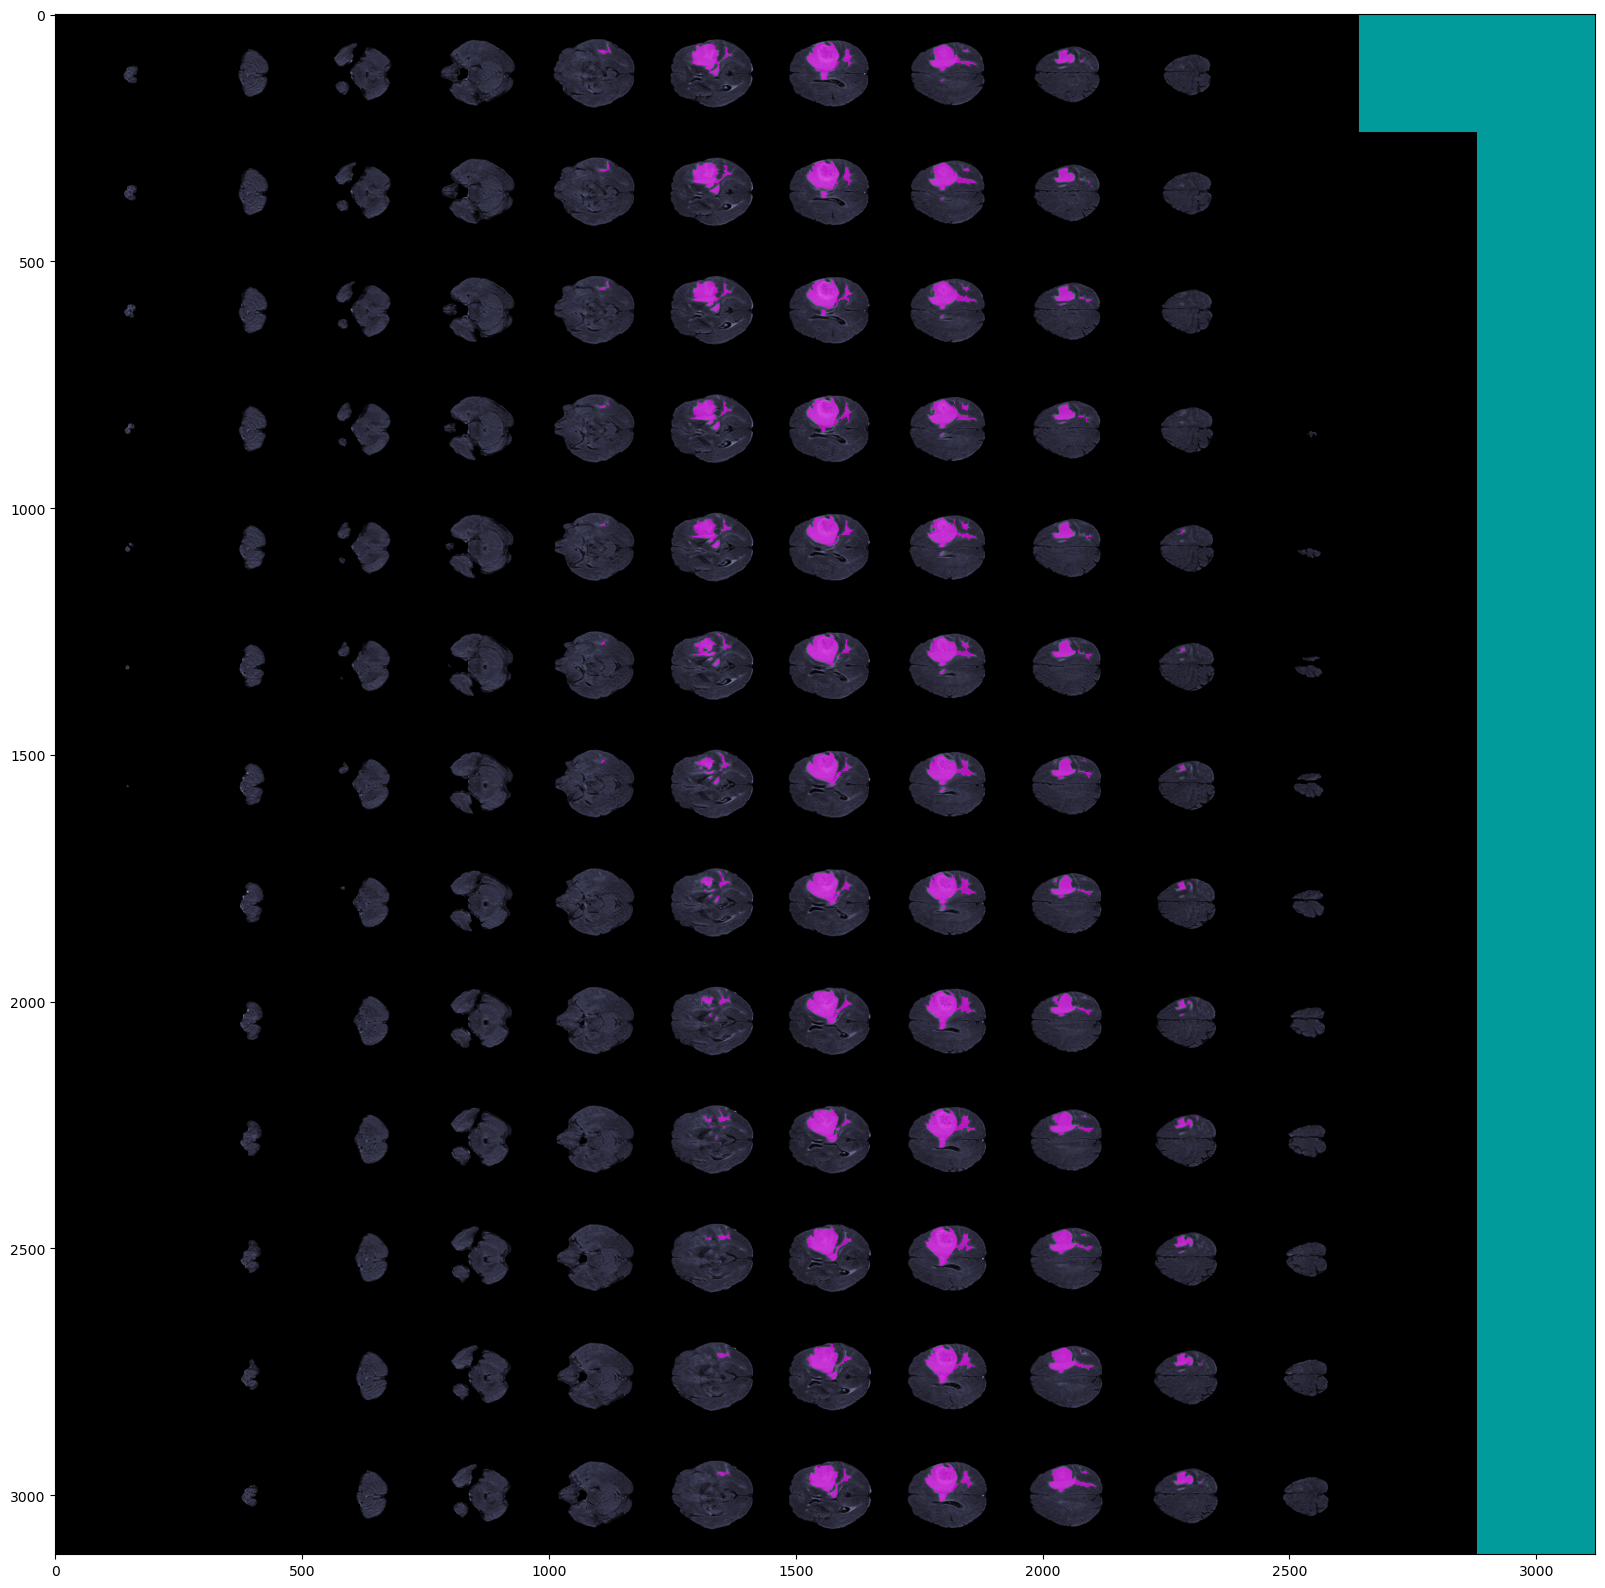

In [44]:

if __name__ == "__main__":

    #sample_test()
    gpu = -1
    device = 'cpu'
    config = GlobalConfig()
    seed_everything(config.seed)

    survival_info_df = pd.read_csv(
        'C://Users//NEW//Desktop//FedTumor//FedTumor//BRATS//Data//Brats2020//BraTS2020_TrainingData//MICCAI_BraTS2020_TrainingData//survival_info.csv')
    name_mapping_df = pd.read_csv(
        'C://Users//NEW//Desktop//FedTumor//FedTumor//BRATS//Data//Brats2020//BraTS2020_TrainingData//MICCAI_BraTS2020_TrainingData//name_mapping.csv')

    name_mapping_df.rename({'BraTS_2020_subject_ID': 'Brats20ID'}, axis=1, inplace=True)

    df = survival_info_df.merge(name_mapping_df, on="Brats20ID", how="right")

    paths = []
    for _, row in df.iterrows():

        id_ = row['Brats20ID']
        phase = id_.split("_")[-2]

        if phase == 'Training':
            path = os.path.join(config.train_root_dir, id_)
        else:
            path = os.path.join(config.test_root_dir, id_)
        paths.append(path)

    df['path'] = paths

    # split data on train, test, split
    # train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=69, shuffle=True)
    # train_df, val_df = train_df.reset_index(drop=True), val_df.reset_index(drop=True)

    train_data = df.loc[df['Age'].notnull()].reset_index(drop=True)
    train_data["Age_rank"] = train_data["Age"] // 10 * 10
    train_data = train_data.loc[train_data['Brats20ID'] != 'BraTS20_Training_355'].reset_index(drop=True, )

    skf = StratifiedKFold(
        n_splits=7, random_state=config.seed, shuffle=True
    )
    for i, (train_index, val_index) in enumerate(
            skf.split(train_data, train_data["Age_rank"])
    ):
        train_data.loc[val_index, "fold"] = i

    train_df = train_data.loc[train_data['fold'] != 0].reset_index(drop=True)
    val_df = train_data.loc[train_data['fold'] == 0].reset_index(drop=True)

    test_df = df.loc[~df['Age'].notnull()].reset_index(drop=True)
    print("train_df ->", train_df.shape, "val_df ->", val_df.shape, "test_df ->", test_df.shape)
    train_data.to_csv("C://Users//NEW//Desktop//FedTumor//FedTumor//train_data.csv", index=False)

    # Dataset DataLoader
    train_val_feddyn()




In [45]:
from cryptography.fernet import Fernet

# Generate a valid Fernet key (32 bytes base64-encoded)
def generate_key():
    return Fernet.generate_key()

# Save the key to a variable
key = generate_key()
print(f"Generated Key: {key.decode()}")


Generated Key: ZAAXQU_BDES8uhNJ8fB7ns7ah4J6cqZPR9BL10Obqig=


In [46]:
def encrypt(data, key):
    """Encrypts the given data using the provided Fernet key."""
    fernet = Fernet(key)
    return fernet.encrypt(data)

def decrypt(encrypted_data, key):
    """Decrypts the given data using the provided Fernet key."""
    fernet = Fernet(key)
    return fernet.decrypt(encrypted_data)


In [47]:
# Generate the key (once, and keep it secure)
key = generate_key()

# Some data to encrypt
data = b"sample data to encrypt"

# Encrypt the data
encrypted_data = encrypt(data, key)
print(f"Encrypted Data: {encrypted_data}")

# Decrypt the data
decrypted_data = decrypt(encrypted_data, key)
print(f"Decrypted Data: {decrypted_data.decode()}")


Encrypted Data: b'gAAAAABm_ukwnHtiFRKccQQIj0_hG3qi9lF9jTbHAMfJzAvjvzckG6BsEnYz4uysNjFhhX3X22p-BknLLX1ku3QFrxMwDveG02mgIcPWJ0NvtQRq6YtgZy4='
Decrypted Data: sample data to encrypt


In [ ]:
data_to_3dgif = Image3dToGIF3d(img_dim=(120, 120, 78), binary=True, normalizing=False)
transformed_data = data_to_3dgif.get_transformed_data(gt)
data_to_3dgif.plot_cube(
        transformed_data,
        title=title,
        make_gif=True,
        path_to_save=filename1
    )
